<a href="https://colab.research.google.com/github/smit-collab/Credit-Card-Fraud-Detection/blob/master/CardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing the required libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
LABELS  = ["Normal","Fraud"]  

In [0]:
# loading the dataset
card_data = pd.read_csv('creditcard.csv')

In [7]:
# exploring the dataset
# getting all the columns in the dataset
print(card_data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


There are total 31 columns and V1 to V28 are result of PCA dimensonality reduction which is used to protect sensitive info of the card in the dataset. So identity,location dosen't get exposed.

Class 0 means valid normal card transaction and 1 means fraudulent transaction.

In [7]:
print(card_data.shape)

(284807, 31)


In [8]:
# getting more info about the data
print(card_data.describe())

                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


the min is 0 and mean is close to 0 meaning we have more valid transactions compared to fraudlent ones.




Text(0, 0.5, 'Frequency')

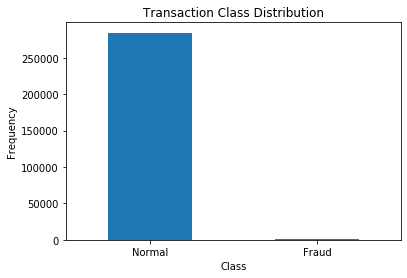

In [30]:
count_classes = pd.value_counts(card_data['Class'],sort = True)
count_classes.plot(kind='bar',rot=0)
plt.title('Transaction Class Distribution')
plt.xticks(range(2),LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')



We can see that normal transaction is more than 250000 and there are less number of fraudulent cases.

In [8]:
# only fraction of this large dataset is considered.
card_data = card_data.sample(frac=0.3,random_state=0)

# now we only have 10% of the data
print(card_data.shape)

(85442, 31)


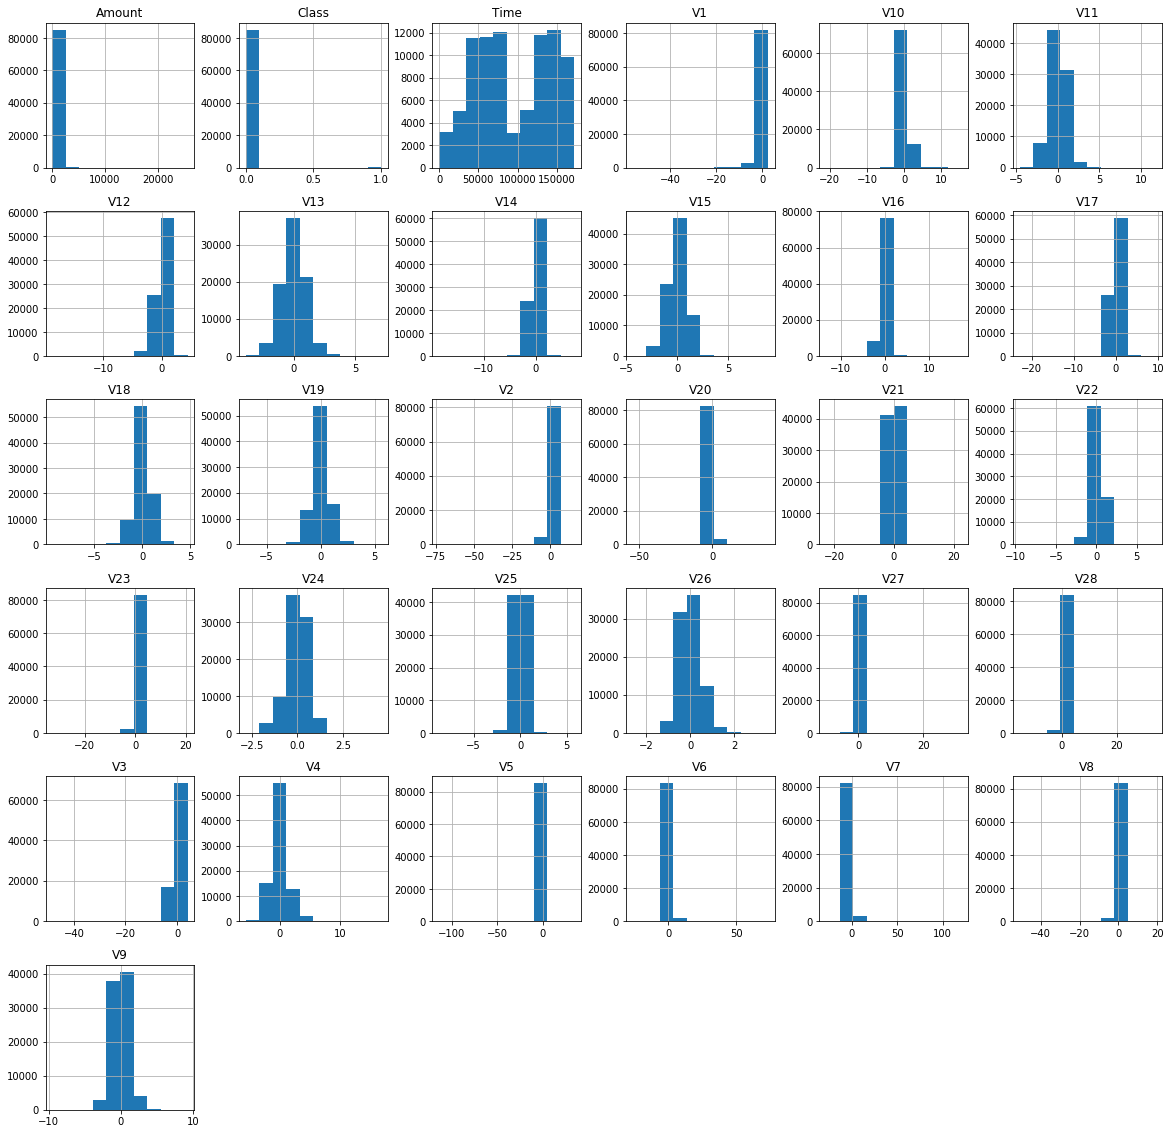

In [9]:
# exploring data visually
card_data.hist(figsize=(20,20))
plt.show()

We can observe that most of the V's are clustered near 0 with some of the outliers present or no outliers.
If we observe the class chart we can see there many valid transactions and very less fraudulent ones.

In [10]:
# getting fraud and valid data 
fraud_data = card_data[card_data['Class']==1]
valid_data = card_data[card_data['Class']==0]

# now getting the percentage of fraud cases to the valid cases
outlierFrac = len(fraud_data)/float(len(valid_data))
print(outlierFrac)
print('Number of Fraud Cases :{} '.format(len(fraud_data)))
print('Number of valid Cases :{}'.format(len(valid_data))) 


0.0017234304472712352
Number of Fraud Cases :147 
Number of valid Cases :85295


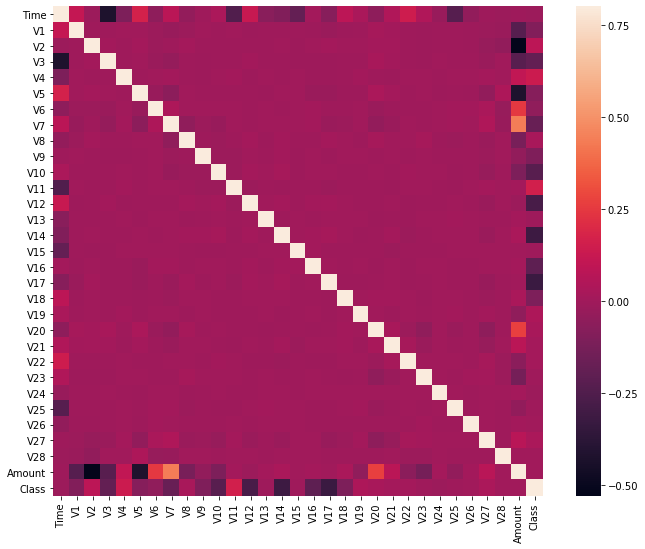

In [11]:
# to check the relationship between var.
# creating correlation matrix.
correlation_matrix = card_data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=.8,square=True)
plt.show()

In [11]:
# formatting the dataset slightly.
columns = card_data.columns.tolist()

# to remove the class column.
columns = [c for c in columns if c not in ["Class"]]
# this is an unsupervised learning so we dont want the label to be fetched to the networks ahead of time.

# predicted var is target
target = "Class" #we are trying to predict

X = card_data[columns] #contains interesting columns
Y = card_data[target] #target col or class.

print(X.shape)
print(Y.shape)

(85442, 30)
(85442,)


In [0]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


# random state
rand_state = 1

# outlier detect methods
#dictionary of diff classifiers
classifiers = {
    # "Support Vector Machine":OneClassSVM(kernel='rbf',degree=3,gamma=0.1,nu=0.05,max_iter=-1,random_state=rand_state),
    
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlierFrac,
                                        random_state=rand_state),
    "Local Outlier Factor": LocalOutlierFactor(
                                        n_neighbors=20,#20 is default but higher number of outliers then higher number of n_neghbors.
                                        contamination=outlierFrac)
                     
}


In [13]:
# fitting the model
number_of_outliers = len(fraud_data)

# looping classifiers
for i,(clf_name,clf) in enumerate (classifiers.items()):
  if clf_name == "Local Outlier Factor":
    y_prediction = clf.fit_predict(X)#will fit all hte columns without the class and the assign labels to them.
    scores_prediction = clf.negative_outlier_factor_
  # elif clf_name == "Support Vector Machine":
  #   clf.fit(X)
  #   y_prediction=clf.predict(X)
  else:
    clf.fit(X)
    scores_prediction=clf.decision_function(X)
    y_prediction = clf.predict(X) 


  # reshaping the prediction values
  # now making the inliners as 0 or valid transactions.
  y_prediction[y_prediction==1]=0

  # and the outliers as 1 or the fraudlenet transactions
  y_prediction[y_prediction==-1]=1
  
  n_errors = (y_prediction!=Y).sum()

  # classification metrics
  print('{},{}'.format(clf_name,n_errors))
  print(accuracy_score(Y,y_prediction))#comparing the actual values and what we think they are
  print(classification_report(Y,y_prediction))  
  

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest,191
0.9977645654362023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.35      0.35      0.35       147

    accuracy                           1.00     85442
   macro avg       0.68      0.68      0.68     85442
weighted avg       1.00      1.00      1.00     85442

Local Outlier Factor,293
0.9965707731560591
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.01      0.01      0.01       147

    accuracy                           1.00     85442
   macro avg       0.50      0.50      0.50     85442
weighted avg       1.00      1.00      1.00     85442



in isolation forest we had 99.6% accuracy and 191 errors and precision of 35% which is lot better.so only 35% actuall fradulent cases were identified. So 35% of time we can find out if the transaction was fradulent or  not.


So we observe that the local outlier factor classifier gave 293 errors and 99.66% accuracy. 
When we look at the precision ,recall and f1 score we see that for class 0 we had precision of 100%  but for class 1 we had really bad precision meaning actual fraudent cases were not being labelled as we thought so. Meaning false positive and false negative were not good at all.

